# Reinforcement Learning - Homework 4

The script implements SARSA and QLearning methods to determine an optimal hitting/sticking strategy for Blackjack. Additionally, Episodic Semi-gradient SARSA is applied to the cart-pole problem in order to determine a strategy that allows for the cart-pole to balance successfully by learning the optimal action (moving left or right at a given velocity) so that balance is maintained for as long as possible.

## Question 1: Blackjack -- Application of SARSA and QLearning

The following code creates Deck, Dealer, and SARSA/QLearning Players in order to simulate the game of Blackjack and determine the optimal policy. The policy yielded by SARSA converges to the optimal policy described in the Sutton and Barto textbook after around 500,000 iterations.

In [ ]:
# required imports
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
# instance variables
HIT = 1
STAND = 0
ACTION_SPACE = [HIT, STAND]
ACE = 11
USABLE_ACE = 1
NO_ACE = 0

In [ ]:
class Deck:
    """ Deck Class and related methods
        Ace is stored as 11
        Card suit is not stored because it is not relevant to Blackjack
    """

    def __init__(self):
        self.deck = []
        for i in range(1, 14):
            if i == 1:
                self.deck += [11]*4

            elif i >= 11:
                self.deck += [10]*4

            else:
                self.deck += [i] * 4

    def deal(self):
        return self.deck.pop(random.randrange(0, len(self.deck)))

    def deal_hand(self):
        hand = []
        for i in range(2):
            hand.append(self.deal())

        return hand

    def reset(self):
        self.deck = []
        for i in range(1, 14):
            if i == 1:
                self.deck += [11] * 4

            elif i >= 11:
                self.deck += [10] * 4

            else:
                self.deck += [i] * 4

In [ ]:
class Dealer:
    """ Dealer Class and related methods
        Dealer policy involves hitting if < 17 and stand otherwise
    """

    def __init__(self, hand):
        self.hand = hand
        self.policy = np.zeros(22)
        self.policy[:17] = HIT
        self.policy[17:] = STAND

    def adjust_ace(self):
        if sum(self.hand) > 21 and self.hand.count(ACE) > 0:
            self.hand.remove(11)
            self.hand.append(1)

    def action(self):
        self.adjust_ace()

        if sum(self.hand) > 21:
            return STAND

        return self.policy[sum(self.hand)]

In [ ]:
class SARSAplayer:
    """ Class for Blackjack player implemented using SARSA
        Default values set to alpha = 0.01, epsilon = 0.1, gamma = 1
    """

    def __init__(self, hand, alpha=0.01, epsilon=0.1, gamma=1):
        self.hand = hand
        self.alpha = alpha
        self.eps = epsilon
        self.gamma = gamma

        # player sum can be up to 31, dealer's card can have value A-10, there can be a usable ace or not, and 2 actions
        self.q = np.zeros((32, 12, 2, 2))

    def adjust_ace(self):
        if sum(self.hand) > 21 and self.hand.count(ACE):
            self.hand.remove(11)
            self.hand.append(1)

    def action(self, state):
        self.adjust_ace()

        if sum(self.hand) == 21:
            return STAND

        if random.random() < self.eps:
            return random.choice(ACTION_SPACE)

        else:
            return random.choice(np.argwhere(self.q[state[0]][state[1]][state[2]] == np.amax(self.q[state[0]][state[1]][state[2]])).flatten())

In [ ]:
class QLearnplayer:
    """ Class for Blackjack player implemented using QLearning
        Default values set to alpha = 0.3, epsilon = 0.1, gamma = 1
    """

    def __init__(self, hand, alpha=0.01, epsilon=0.2, gamma=1):
        self.hand = hand
        self.alpha = alpha
        self.eps = epsilon
        self.gamma = gamma
        self.q = np.zeros((32, 12, 2, 2))

    def adjust_ace(self):
        if sum(self.hand) > 21 and self.hand.count(ACE):
            self.hand.remove(11)
            self.hand.append(1)

    def action(self, state):
        self.adjust_ace()

        if sum(self.hand) == 21:
            return STAND

        if random.random() < self.eps:
            return random.choice(ACTION_SPACE)

        else:
            return random.choice(np.argwhere(self.q[state[0]][state[1]][state[2]] == np.amax(self.q[state[0]][state[1]][state[2]])).flatten())

In [ ]:
class Blackjack:
    def __init__(self, sarsa=True):
        self.deck = Deck()

        if sarsa:
            self.player = SARSAplayer(self.deck.deal_hand())
        else:
            self.player = QLearnplayer(self.deck.deal_hand())

        self.sarsa = sarsa
        self.dealer = Dealer(self.deck.deal_hand())

    def play(self): # player gets to see 1 of dealer's cards
        self.deck = Deck()
        self.player.hand = self.deck.deal_hand()
        self.player.adjust_ace()
        self.dealer.hand = self.deck.deal_hand()
        self.dealer.adjust_ace()

        s = (sum(self.player.hand), self.dealer.hand[0], 1 if self.player.hand.count(ACE) else 0)
        a = self.player.action(s)
        terminal = False

        s_prime, a_prime = s, a

        while True:
            if a == HIT:
                self.player.hand.append(self.deck.deal())
                self.player.adjust_ace()

                if sum(self.player.hand) >= 21:
                    next_state_value = 0
                    reward = self.check_game()
                    terminal = True

                else:
                    s_prime = (sum(self.player.hand), self.dealer.hand[0], 1 if self.player.hand.count(ACE) > 0 else 0)
                    a_prime = self.player.action(s_prime)

                    if self.sarsa:
                        next_state_value = self.player.q[s_prime[0]][s_prime[1]][s_prime[2]][a_prime]

                    else:
                        next_state_value = np.max(self.player.q[s_prime[0]][s_prime[1]][s_prime[2]])

                    reward = 0

            else:  # action is STAND, next state is terminal
                next_state_value = 0
                reward = self.check_game()
                terminal = True

            self.player.q[s[0]][s[1]][s[2]][a] += self.player.alpha * (reward + self.player.gamma * next_state_value - self.player.q[s[0]][s[1]][s[2]][a])
            s = s_prime

            if self.sarsa:
                a = a_prime

            else:
                a = self.player.action(s)

            if terminal:
                break

    def check_game(self):
        # check if player has bust
        if sum(self.player.hand) > 21:
            return -1

        while self.dealer.action() == HIT:
            self.dealer.hand.append(self.deck.deal())

        if sum(self.dealer.hand) > 21 or sum(self.player.hand) > sum(self.dealer.hand):
            return 1

        elif sum(self.player.hand) == sum(self.dealer.hand):
            return 0

        else:
            return -1

In [ ]:
def plot_blackjack_values(Q):
    def get_Z(x, y, usable_ace):
        return np.sum(Q[x, y, usable_ace, :])

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(2, 12)
        X, Y = np.meshgrid(x_range, y_range)

        Z = np.array([get_Z(x, y, usable_ace) for x, y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(USABLE_ACE, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(NO_ACE, ax)
    plt.show()

In [ ]:
def plot_policy(Q):
    def get_Z(x, y, usable_ace):
        return np.argmax(Q[x, y, usable_ace, :])

    def get_figure(usable_ace, ax):
        x_range = np.arange(12, 22) if usable_ace == 1 else np.arange(11, 22)
        y_range = np.arange(11, 1, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x, y, usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0, 1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)', '1 (HIT)'])

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(USABLE_ACE, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(NO_ACE, ax)
    plt.show()

### Run SARSA 500,000 times:

100%|██████████| 500000/500000 [00:31<00:00, 15781.77it/s]


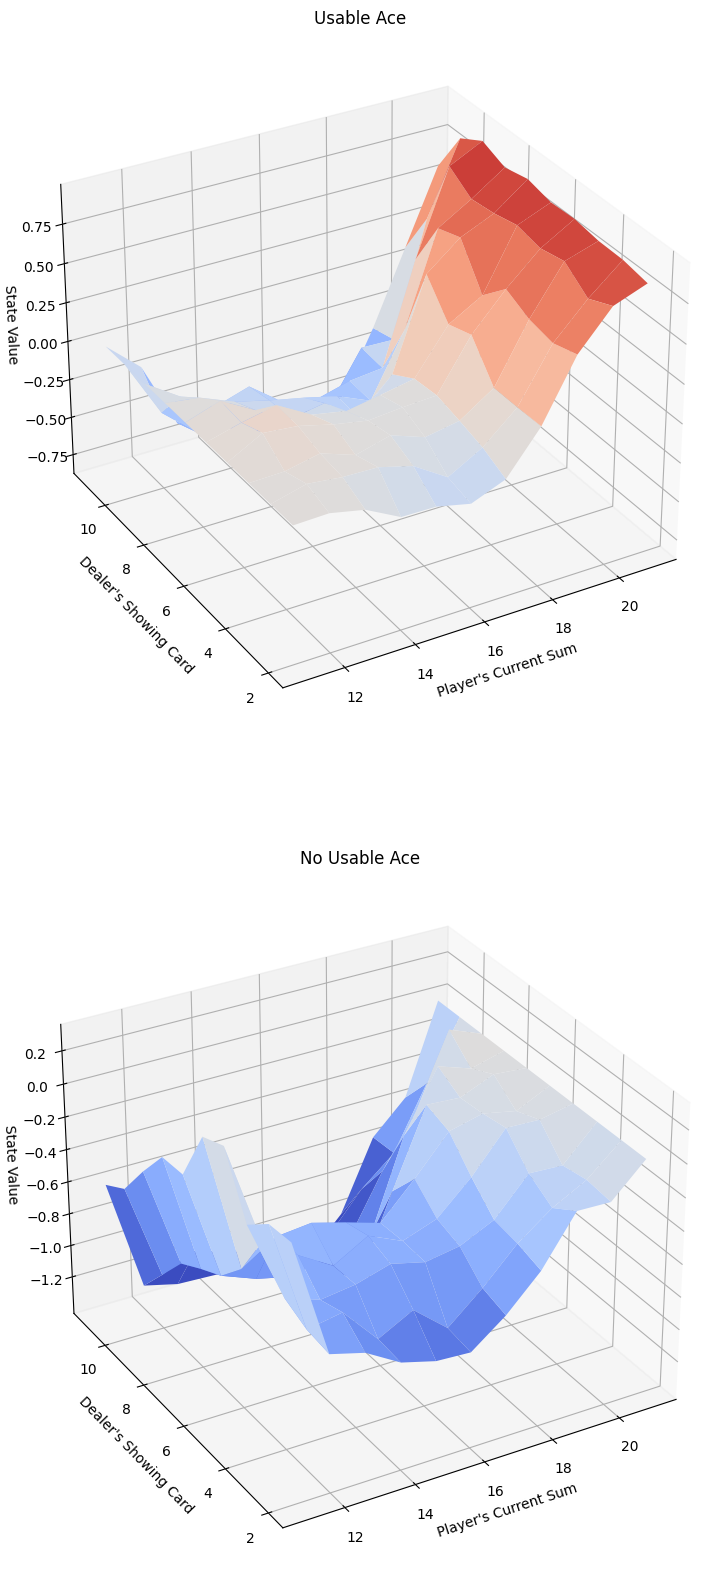

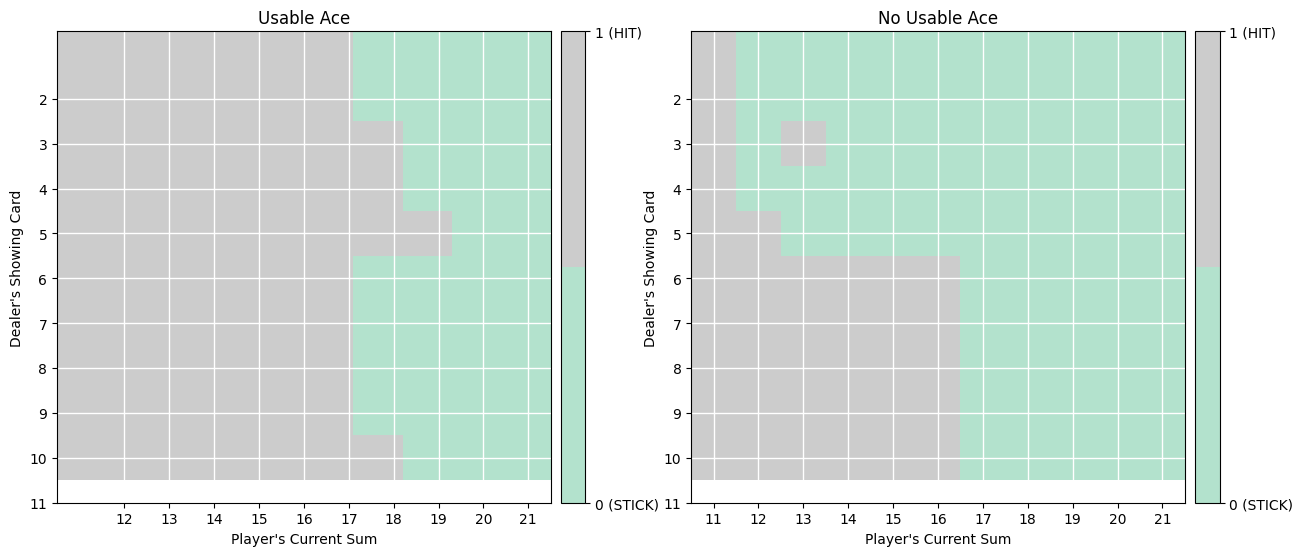

In [ ]:
if __name__ == "__main__":
    game = Blackjack(sarsa=True)
    N = 500000

    for i in tqdm(range(N)):
        game.play()

    Q = game.player.q
    plot_blackjack_values(Q)
    plot_policy(Q)

Policy found from running SARSA 500,000 times with 0.01 learning rate (alpha)


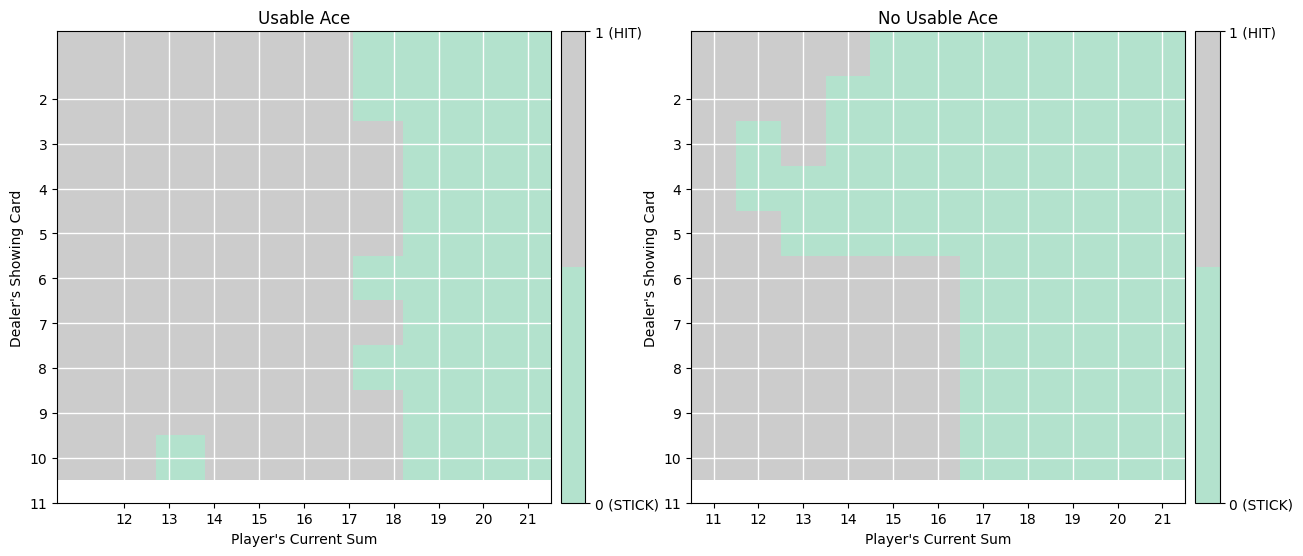

### Run QLearning 300,000 times:

100%|██████████| 300000/300000 [00:25<00:00, 11545.75it/s]


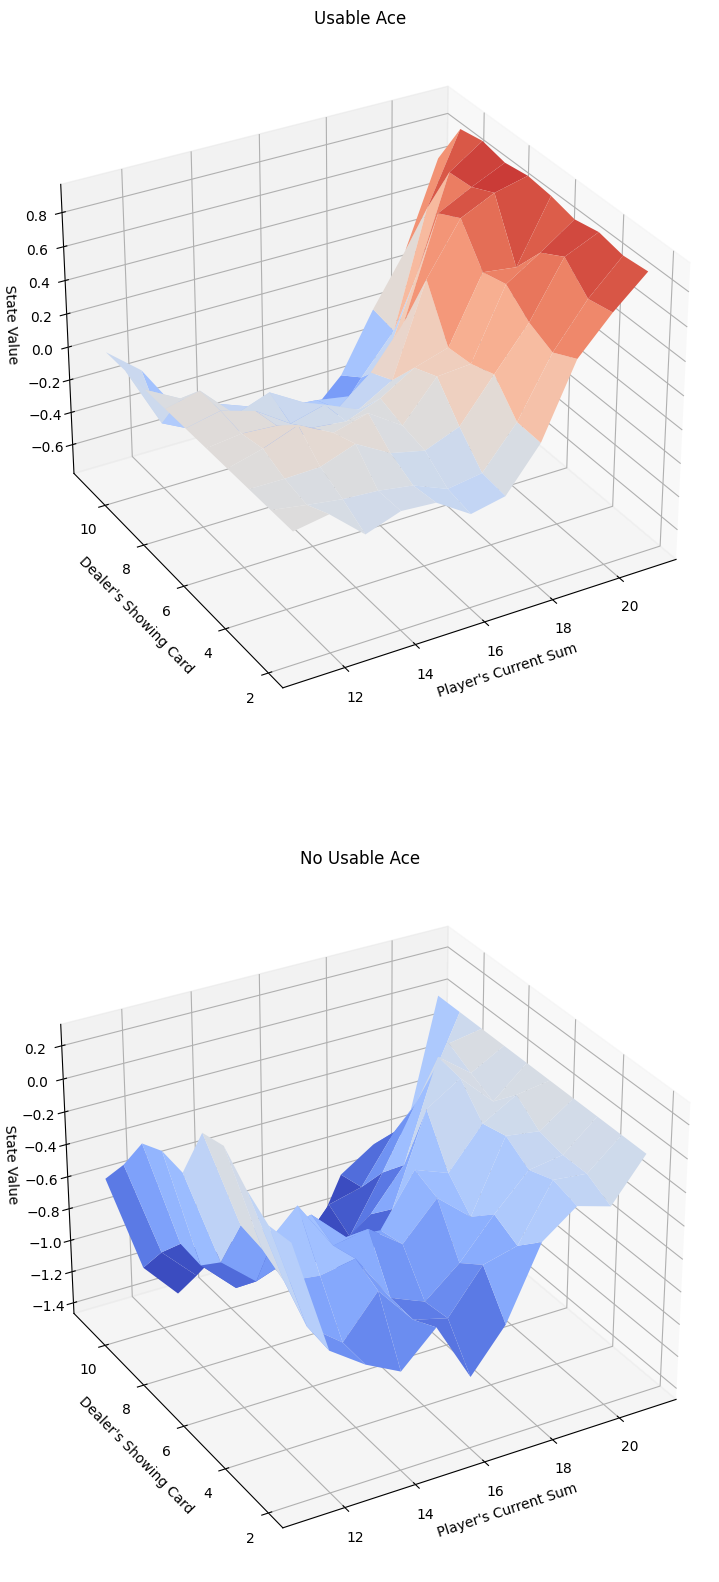

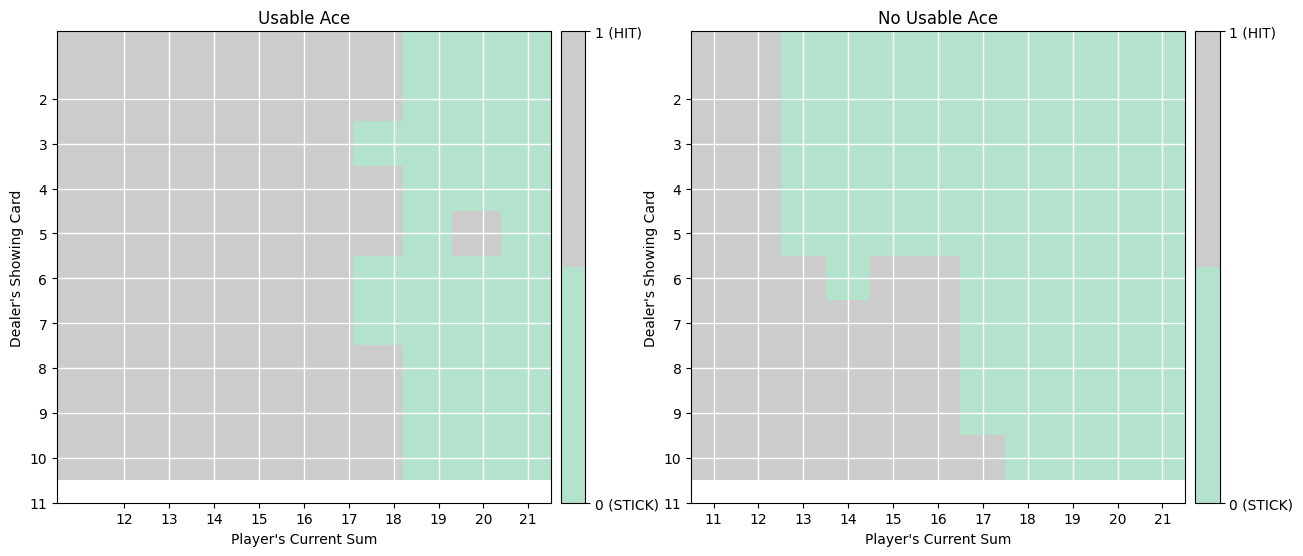

In [ ]:
if __name__ == "__main__":
    game = Blackjack(sarsa=False)
    N = 300000

    for i in tqdm(range(N)):
        game.play()

    Q = game.player.q
    plot_blackjack_values(Q)
    plot_policy(Q)

Comparatively, the QLearning algorithm also acheives similar convergence to the optimal policy within 300,000 iterations.

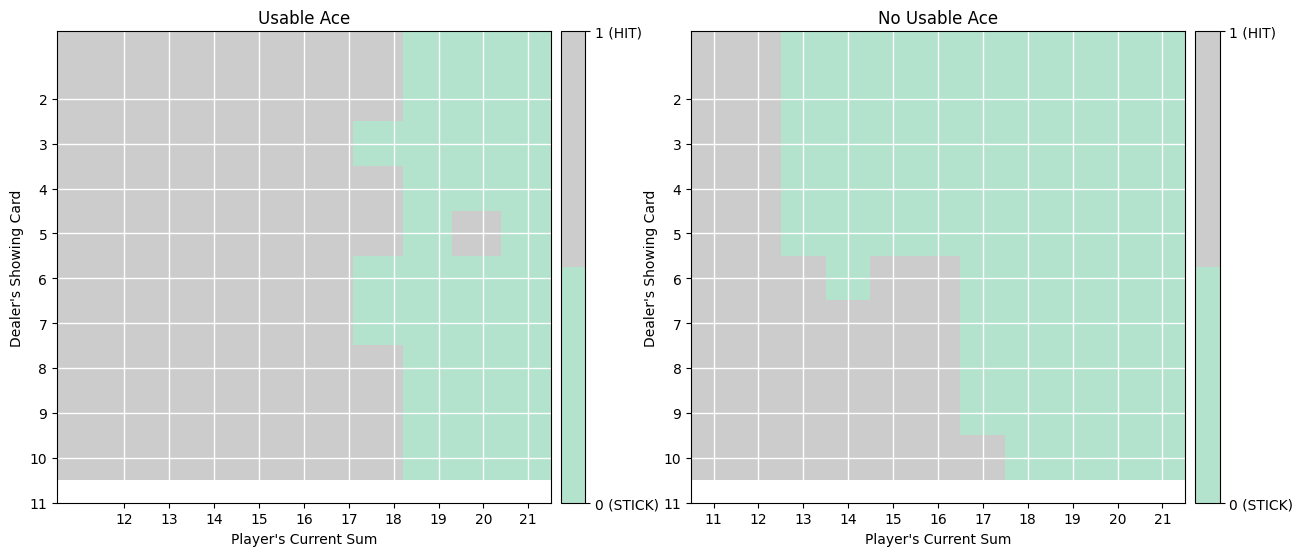

## Question 2: Cart Pole with Episodic Semi-gradient SARSA

In [ ]:
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 13.3 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
class EpisodicSARSA:
    def __init__(self, env, q, grad_q, n=5000, alpha=0.1, epsilon=0.1, gamma=0.99):
        self.env = env
        self.q = q
        self.gradient = grad_q

        self.num_episodes = n
        self.alpha = alpha
        self.eps = epsilon
        self.gamma = gamma

        shape = (env.action_space.n, *env.observation_space.shape)
        print(shape)
        self.w = np.zeros(shape)

    def simulate(self):
        rewards = []

        for i in tqdm(range(self.num_episodes)):
            s = self.env.reset()[0]
            a = self.action(s)
            episode_rewards = []

            while True:
                s_prime, reward, done, info, _ = self.env.step(a)
                episode_rewards.append(reward)

                if done:
                    self.w[a] += self.alpha * (reward - self.q(s, a, self.w[a])) * self.gradient(s, a, self.w[a])
                    break

                a_prime = self.action(s_prime)
                self.w[a] += self.alpha * (reward + self.gamma * self.q(s_prime, a_prime, self.w[a]) - self.q(s, a, self.w[a])) * self.gradient(s, a, self.w[a])
                s, a = s_prime, a_prime

            rewards.append(sum(episode_rewards))

        return rewards

    def action(self, state):
        if np.random.random() < self.eps:  # exploration
            return np.random.choice(self.env.action_space.n)

        else:
            greedy_actions = []
            max_value = -np.inf

            for action in range(self.env.action_space.n):
                value = self.q(state, action, self.w[action])

                if value >= max_value:
                    max_value = value
                    greedy_actions.append(action)

            return np.random.choice(greedy_actions)

In [ ]:
# Define linear and gradient functions
def linear_q(state, action, w):
    x = np.array(state)
    return np.dot(np.transpose(w), x)

def gradient_q(state, action, w):
    x = np.array(state)
    return x

(2, 4)


100%|██████████| 10000/10000 [00:15<00:00, 656.04it/s]


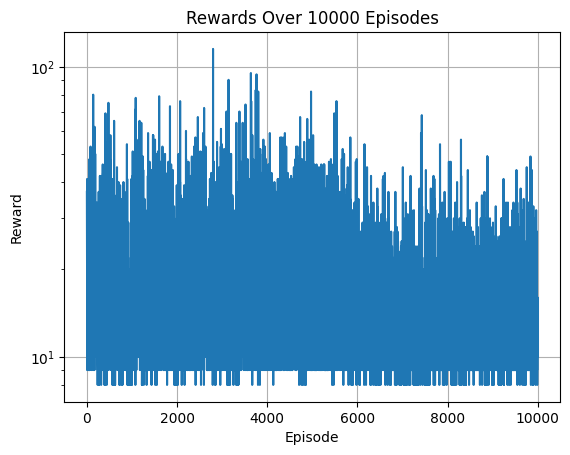

In [ ]:
if __name__ == "__main__":
    N = 10000
    environment = gym.make("CartPole-v1")
    cartpole = EpisodicSARSA(env=environment, q=linear_q, grad_q=gradient_q, n=N)
    rewards = cartpole.simulate()
    plt.plot(range(len(rewards)), rewards)
    plt.title("Rewards Over " + str(N) + " Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.yscale("log")
    plt.grid()
    plt.show()

In [ ]:
print(max(rewards))
print(cartpole.w)

115.0
[[ 25.52853609  11.79860501 -55.66357048  12.69163691]
 [ -0.99740663  -6.15705422   5.37029264  -3.91512236]]
